In [ ]:
from utils.decoding import decode, flip


In [1]:
%cd /Users/masha/Documents/GSOC/GSoC-Quantum-Diffusion-Model

from utils.post_training import *
from utils.statistics import *
from utils.plotting import *
from utils.encodings import *
from utils.statistics import calculate_statistics, calculate_fid, ssim
from utils.haar_noising_script import apply_global_haar_scrambling

import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy.linalg

import pennylane as qml

def visualize_encoded_data(encoded_data, sample_index=0):
    encoded_sample = encoded_data[sample_index]

    fig, axes = plt.subplots(1, 4, figsize=(20, 5)) 
    for channel in range(4):
        ax = axes[channel]
        encoded_image = encoded_sample[:, :, channel]
        im = ax.imshow(encoded_image, cmap='viridis')
        fig.colorbar(im, ax=ax)
        ax.set_title(f'Channel {channel+1}')
    plt.show()

c:\Users\realc\OneDrive\Documents\GSOC\.venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


C:\Users\realc\OneDrive\Documents\GSOC


torch.Size([100, 8, 8, 4])
torch.Size([100, 8, 8, 4])


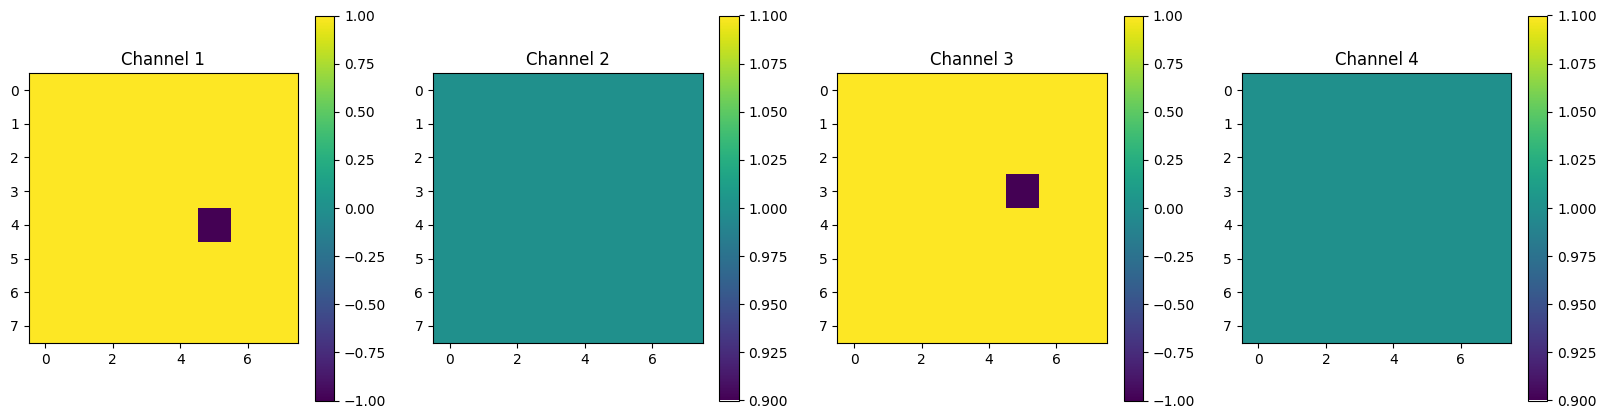

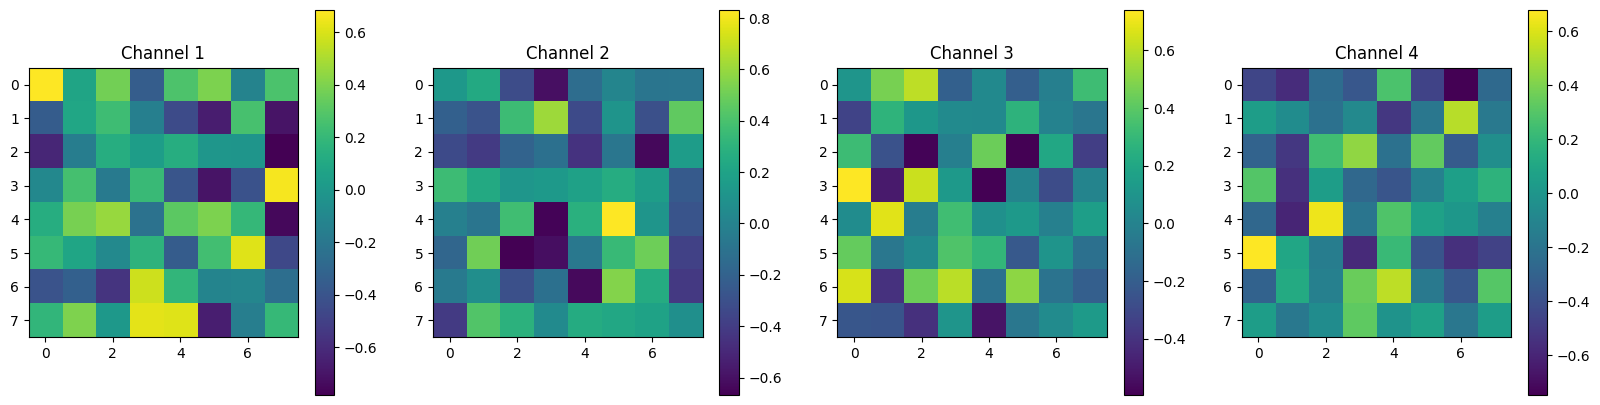

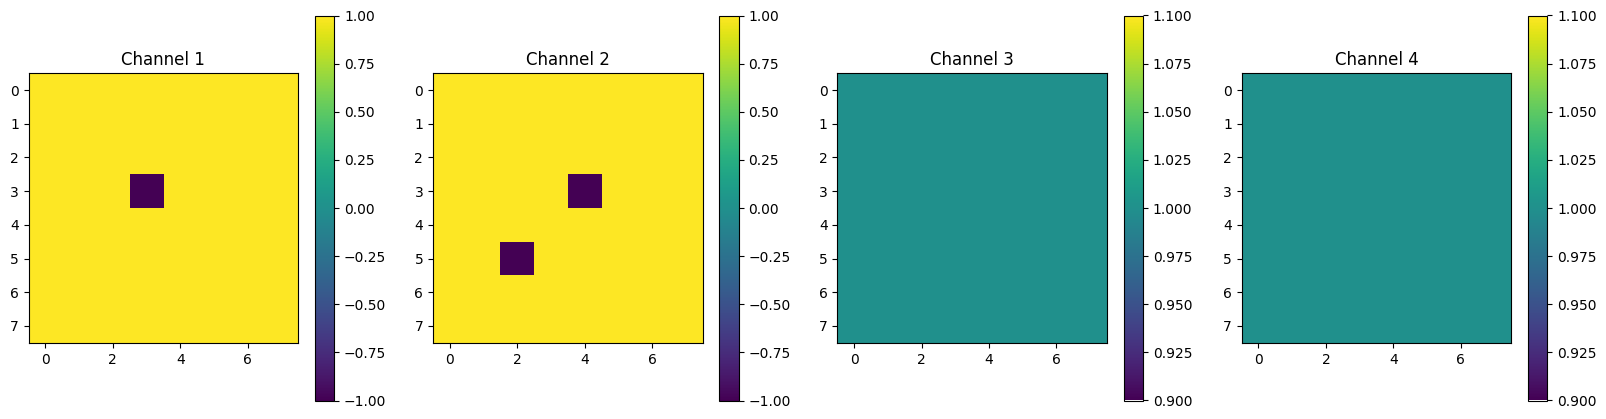

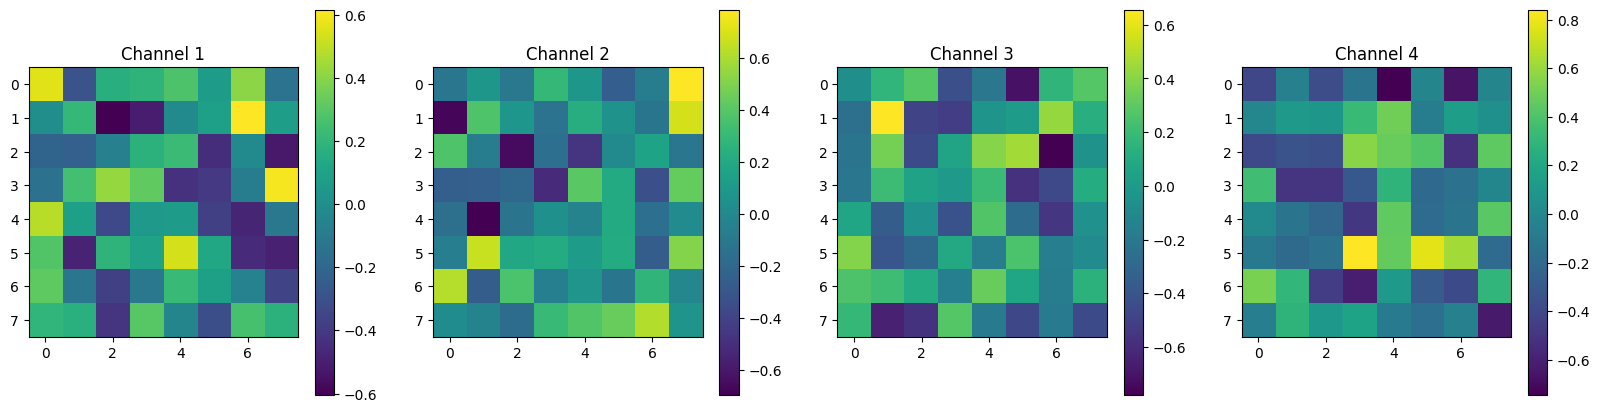

In [ ]:
filename = "../../../data/QG1_normalized_16_xl"
data_X = np.array(h5py.File(filename, "r")['X'])

num_samples = 100

encoded_data = [angle_encoding(data_X, sample) for sample in range(num_samples)]
encoded_data = torch.tensor(np.array(encoded_data), dtype=torch.float32)
print(encoded_data.shape)

scrambled_states = apply_haar_scrambling(np.array(encoded_data), num_samples, seed=42)
scrambled_states = torch.tensor(scrambled_states, dtype=torch.float32)
print(scrambled_states.shape)

visualize_encoded_data(encoded_data, sample_index=0)
visualize_encoded_data(scrambled_states, sample_index=0)
visualize_encoded_data(encoded_data, sample_index=1)
visualize_encoded_data(scrambled_states, sample_index=1)

C:\Users\realc\OneDrive\Documents\GSOC


C:\Users\realc\AppData\Local\Temp\ipykernel_11876\889960977.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoded_data_load = torch.load(f"data/QG1_64x64_100_encoded.p

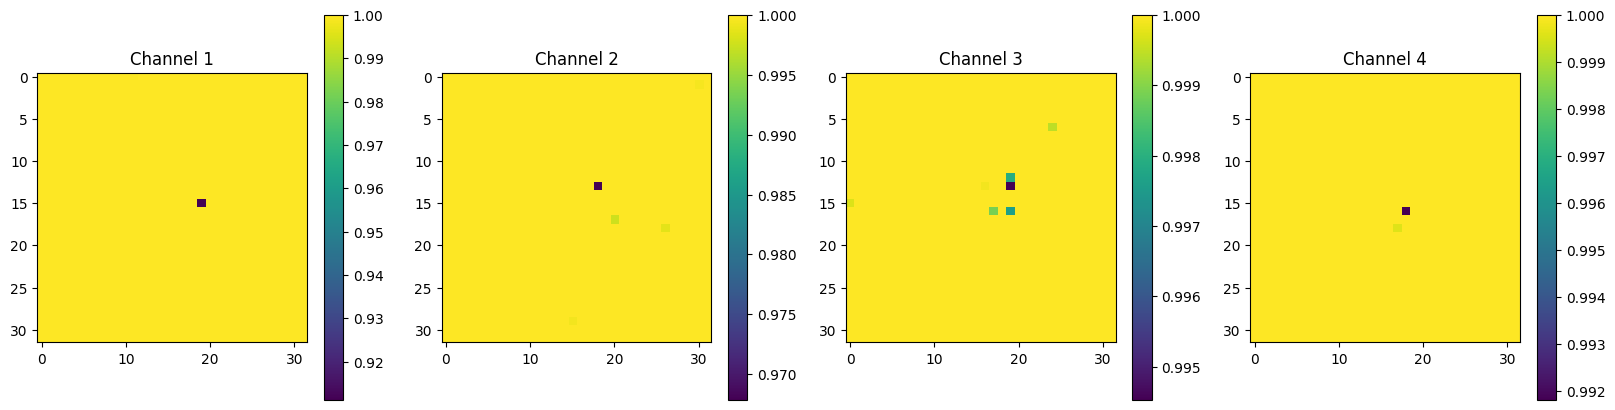

In [17]:
%cd /Users/masha/Documents/GSOC/GSoC-Quantum-Diffusion-Model

encoded_data_load = torch.load(f"data/QG1_64x64_100_encoded.pt")
visualize_encoded_data(encoded_data_load, sample_index=0)


In [22]:
decoded = 1 - decode(encoded_data_load)

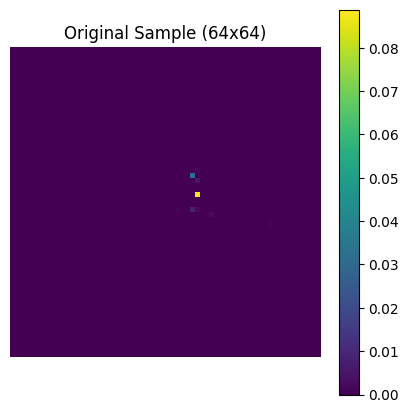

In [24]:
import matplotlib.pyplot as plt

# decoded: shape (num_samples, 64, 64)
sample_index = 0
plt.figure(figsize=(5, 5))
plt.imshow(decoded[sample_index], cmap='viridis')  # Or 'gray' if it's grayscale
plt.title("Original Sample (64x64)")
plt.axis('off')
plt.colorbar()
plt.show()


In [2]:
QG_channel = 1
filename = f"data/QG{QG_channel}_64x64_1k"
data_X = np.array(h5py.File(filename, "r")['X'])

num_samples = 10

encoded_data_load = torch.load(f"data/QG{QG_channel}_64x64_1000_encoded.pt")[:num_samples]
print(encoded_data_load.shape)

scrambled_states, used_unitaries = apply_global_haar_scrambling(np.array(encoded_data_load), seed=42, approx_threshold_qubits=200)
print("scrambled_states.shape:", scrambled_states.shape)  # (num_samples, 2**n)


C:\Users\realc\AppData\Local\Temp\ipykernel_19192\2636020861.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoded_data_load = torch.load(f"data/QG{QG_channel}_64x64_1

torch.Size([10, 32, 32, 4])
scrambled_states.shape: (10, 4096)


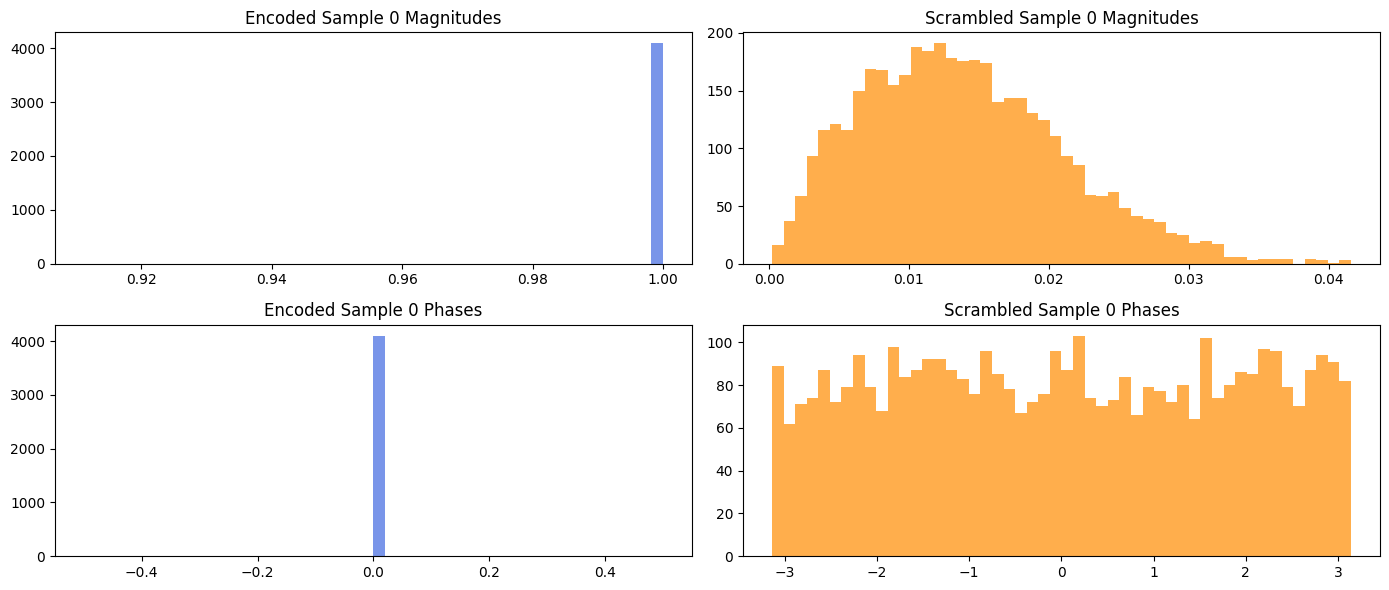

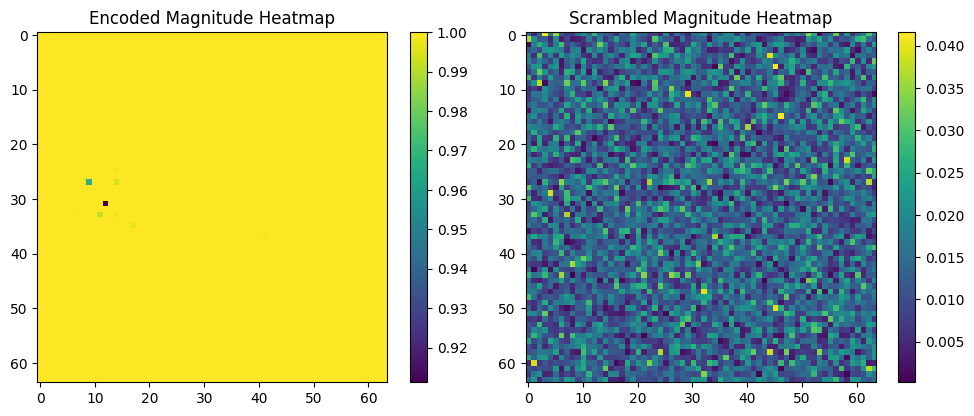

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_comparison(encoded_states, scrambled_states, sample_idx=0):
    # Flatten encoded sample so it matches scrambled shape
    enc = encoded_states[sample_idx].reshape(-1)
    scr = scrambled_states[sample_idx]

    enc_mag, scr_mag = np.abs(enc), np.abs(scr)
    enc_phase, scr_phase = np.angle(enc), np.angle(scr)

    plt.figure(figsize=(14, 6))

    # Magnitude histograms
    plt.subplot(2, 2, 1)
    plt.hist(enc_mag, bins=50, color="royalblue", alpha=0.7)
    plt.title(f"Encoded Sample {sample_idx} Magnitudes")

    plt.subplot(2, 2, 2)
    plt.hist(scr_mag, bins=50, color="darkorange", alpha=0.7)
    plt.title(f"Scrambled Sample {sample_idx} Magnitudes")

    # Phase histograms
    plt.subplot(2, 2, 3)
    plt.hist(enc_phase, bins=50, color="royalblue", alpha=0.7)
    plt.title(f"Encoded Sample {sample_idx} Phases")

    plt.subplot(2, 2, 4)
    plt.hist(scr_phase, bins=50, color="darkorange", alpha=0.7)
    plt.title(f"Scrambled Sample {sample_idx} Phases")

    plt.tight_layout()
    plt.show()

    dim = int(np.sqrt(len(enc)))
    if dim * dim == len(enc):
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.imshow(enc_mag.reshape(dim, dim), cmap="viridis")
        plt.colorbar()
        plt.title("Encoded Magnitude Heatmap")

        plt.subplot(1,2,2)
        plt.imshow(scr_mag.reshape(dim, dim), cmap="viridis")
        plt.colorbar()
        plt.title("Scrambled Magnitude Heatmap")

        plt.tight_layout()
        plt.show()


visualize_comparison(encoded_data_load, scrambled_states, sample_idx=0)


C:\Users\realc\AppData\Local\Temp\ipykernel_21080\420647650.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


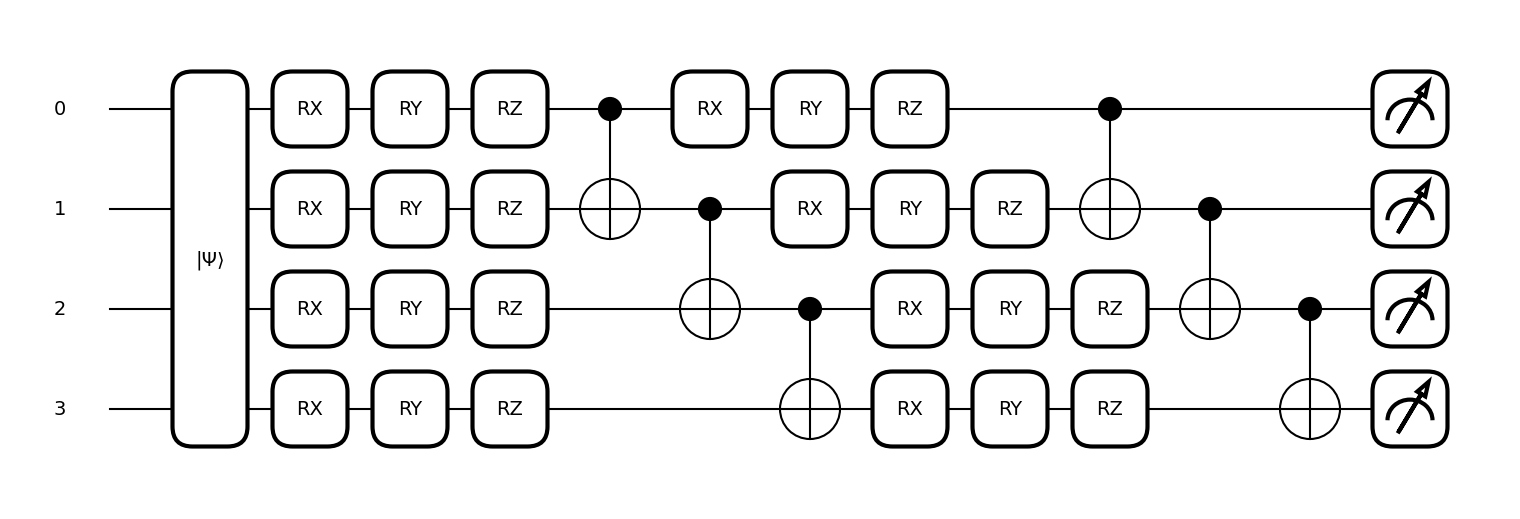

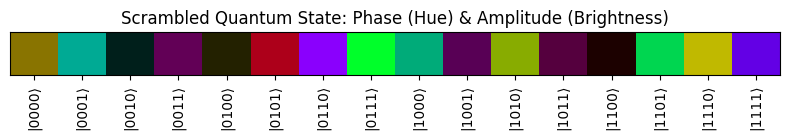

In [ ]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from utils.haar_noising_script import fast_haar_scramble

# Initially |0000⟩ state
n_qubits = 4
dim = 2**n_qubits
encoded_vector = np.zeros(dim)
encoded_vector[0] = 1.0

seed = 42
depth = 2
circuit, scrambled_state = fast_haar_scramble(encoded_vector, n_qubits, depth, seed)

fig_circ = qml.draw_mpl(circuit)(encoded_vector)
plt.tight_layout()
plt.show()

# Visualize random circuit for presentation
magnitude = np.abs(scrambled_state)
phase = np.angle(scrambled_state)

hsv_img = np.zeros((1, dim, 3))
hsv_img[0,:,0] = (phase + np.pi) / (2 * np.pi)
hsv_img[0,:,1] = 1.0
hsv_img[0,:,2] = magnitude / np.max(magnitude)
rgb_img = hsv_to_rgb(hsv_img)

plt.figure(figsize=(8, 1.5))
plt.imshow(rgb_img, aspect='auto')